# Using EMC² to Process SCREAM Output using New SCREAM Model Class

Add precipitating ice category using precipitating ice fraction and Apply binary fraction for all hydrometeors
---

#### EMC² can be used to simulate radar and lidar observables faithful to large-scale model physics. Here, we will demonstrate using EMC² to evaluate a climate model's output. We will process E3SM regional output around the fixed ARM site at Utqiagvik, North Slope of Alaska site, using EMC² radiation approach (fastest processing; faithful to E3SM's radiation logic; similar general approach to that used for the on-line COSP). 
#### We will briefly explore:
1. Reading model output file using EMC²
1. Generating subcolumns and running the radar and lidar instrument simualtors
1. Classifying the simulator output
1. Plotting the simulated observables to evaluate the model output

## Imports

In [1]:
import emc2
import numpy as np
import xarray as xr

## Initializing Instrument Class Objects

#### We begin with generating instrument class objects representing instruments deployed at Utqiagvik; that is, high spectral resolution lidar (HSRL) `emc2.core.instruments.HSRL` and ARM Ka-band Zenith Radar (KAZR) `emc2.core.instruments.KAZR` objects. Among other radar and lidar instruments, EMC² includes instrument sub-classes for the full ARM radar and lidar instrument suite. Note that in the case of the KAZR class object (as in the case of different radar object) we specify the ARM site string to initialize the KAZR class object with the correct radar attributes.

In [2]:
# Set instrument class objects to simulate (a radar and a lidar)
KAZR = emc2.core.instruments.KAZR('nsa')
HSRL = emc2.core.instruments.HSRL()
print("Instrument class generation done!")

Instrument class generation done!


## Initializing a Model Class Object

#### Let's take a look at the model output data file from EAM (E3SM's atmospheric component) using the `xarray` Python package.

In [3]:
# Path to E3SM output file
model_path = './example_data/scream_dp_comble_anx.2020-03-01.demo.nc'
xr.open_dataset(model_path)

<xarray.Dataset>
Dimensions:                 (time: 121, lev: 128, ncol: 3)
Coordinates:
  * time                    (time) datetime64[ns] 2020-03-01 ... 2020-03-06
  * lev                     (lev) float64 2.58 3.23 3.88 ... 991.0 994.9 998.5
Dimensions without coordinates: ncol
Data variables: (12/27)
    CLDLIQ                  (time, lev, ncol) float64 ...
    CLDICE                  (time, lev, ncol) float64 ...
    RAINQM                  (time, lev, ncol) float64 ...
    lambda_cloud            (time, lev, ncol) float64 ...
    mu_cloud                (time, lev, ncol) float64 ...
    NUMLIQ                  (time, lev, ncol) float64 ...
    ...                      ...
    hyam                    (time, lev) float64 ...
    hybm                    (time, lev) float64 ...
    PS                      (time, ncol) float64 ...
    ICE_CLOUD_FRAC          (time, lev, ncol) float64 ...
    LIQ_CLOUD_FRAC          (time, lev, ncol) float64 ...
    PRECIPITATING_ICE_FRAC  (time, lev, ncol) float64 ...

#### Instead of explicitly using the xarray package to load the data, EMC² can automatically load the data file when generating an `emc2.core.model.E3SM` object. By using EMC² to load a large-scale model's output, we are able to handle 2 potential issues exemplified in the examined E3SM output file:
1. Because E3SM operates a cube-sphere grid, data is not provided in a strict lat-lon grid (two spatial dimensions) but rather on a column basis (one spatial dimension). We need to inform EMC² about that by setting `all_appended_in_lat=True`.
1. The regional output file has appended strings at the end of every field name, the result of post-processing machinery. By setting `appended_str=True`, EMC² can remove these strings by using one of EMC²'s internal methods invoked during initialization.

#### Let's generate an `emc2.core.model.E3SM` object and examine how the loaded data file is shown after initialization as an `xr.Dataset` object.

In [4]:
# Set model class object to use and load output file.
my_e3sm = emc2.core.model.SCREAM(model_path, all_appended_in_lat=True, appended_str=True, single_ice_class=True, include_rain_in_rt=True, N_sub=1)
my_e3sm.ds  # shows the loaded dataset

no dimension name with an appended string found
./example_data/scream_dp_comble_anx.2020-03-01.demo.nc is a regional output dataset; Stacking the time, lat, and lon dims for processing with EMC^2.


<xarray.Dataset>
Dimensions:                 (lev: 128, time_lat_lon: 363, ncol_tmp: 3,
                             time_tmp: 121)
Coordinates:
  * lev                     (lev) float64 998.5 994.9 991.0 ... 3.88 3.23 2.58
  * ncol_tmp                (ncol_tmp) int64 0 1 2
  * time_tmp                (time_tmp) datetime64[ns] 2020-03-01 ... 2020-03-06
  * time_lat_lon            (time_lat_lon) object MultiIndex
  * ncol                    (time_lat_lon) int64 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2
  * time                    (time_lat_lon) datetime64[ns] 2020-03-01 ... 2020...
Data variables: (12/35)
    CLDLIQ                  (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    CLDICE                  (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    RAINQM                  (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    lambda_cloud            (time_lat_lon, lev) float64 0.0 0.0 ... 2.52e+05
    mu_cloud                (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 5.3 5.3
    NUMLIQ                  (time_lat_lon, lev) float64 1.279e-18 ... 4.142e-21
    ...                      ...
    rho_a                   (time_lat_lon, lev) float64 dask.array<chunksize=(363, 128), meta=np.ndarray>
    zeros_ns                (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    zeros_cfr               (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    zeros_cfs               (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    zeros_res               (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
    zeros_qs                (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    _file_dates:          ['20200301']
    _file_times:          ['000000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

#### Now, we use the `emc2.simulator.main.make_simulated_data` method to have EMC² perform a set of (optional) tasks:
1. Generate user-specified number of subcolumns per model grid cell.
1. Run the instrument simualtor.
1. Classify hydrometeor phase using the simulated observables.

#### We first call the `emc2.simulator.main.make_simulated_data` method to calculate the HSRL observables and then call it again to calcualte the KAZR observables (without invoking the subcolumn generator methods again). 
#### Note that because the model output contains the spatial dimension stacked onto the time dimension, we wish to unstack these dimensions once all simualtor operations are done by setting `unstack_dims=True`. 
* because the simulator is being run here using a 10-yr old machine, the processing timing printed on the screen is relatively longer than one should typically expect. 

In [5]:
#Specify number of subcolumns and run simulator (first, for the lidar, then the radar) 
N_sub = 1
my_e3sm = emc2.simulator.main.make_simulated_data(my_e3sm, HSRL, N_sub, do_classify=True, convert_zeros_to_nan=True,use_rad_logic=True)
print("lidar processing done!")
my_e3sm = emc2.simulator.main.make_simulated_data(my_e3sm, KAZR, N_sub, do_classify=True, convert_zeros_to_nan=True,
                                                   unstack_dims=True, skip_subcol_gen=True, finalize_fields=True,use_rad_logic=True)
print("radar processing done!")

## Creating subcolumns...
No convective processing for SCREAM
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.00s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
Generating lidar moments...
Generating stratiform lidar variables us

#### We can examine the simulator output dataset saved under an `xr.Dataset` object. We can see that for most lidar and radar observables (the equivalent reflectivity factor Ze, the backscatter cross-section beta_p, etc.) we have fields per hydrometeor class in addition to the field representing the total.

In [6]:
my_e3sm.ds

<xarray.Dataset>
Dimensions:                           (lev: 128, time: 121, ncol: 3)
Coordinates:
  * lev                               (lev) float64 998.5 994.9 ... 3.23 2.58
  * ncol                              (ncol) int64 0 1 2
  * time                              (time) datetime64[ns] 2020-03-01 ... 20...
    subcolumn                         int64 0
Data variables: (12/98)
    CLDLIQ                            (time, lev, ncol) float64 0.0 0.0 ... 0.0
    CLDICE                            (time, lev, ncol) float64 0.0 0.0 ... 0.0
    RAINQM                            (time, lev, ncol) float64 0.0 0.0 ... 0.0
    lambda_cloud                      (time, lev, ncol) float64 0.0 ... 2.52e+05
    mu_cloud                          (time, lev, ncol) float64 0.0 0.0 ... 5.3
    NUMLIQ                            (time, lev, ncol) float64 1.279e-18 ......
    ...                                ...
    sub_col_Ze_att_tot_strat          (time, lev, ncol) float64 nan nan ... nan
    Ze_min                            (time, lev, ncol) float64 -78.55 ... -1...
    sub_col_Ze_tot                    (time, lev, ncol) float64 nan nan ... nan
    sub_col_Ze_att_tot                (time, lev, ncol) float64 nan nan ... nan
    detect_mask                       (time, lev, ncol) bool False ... False
    phase_mask_KAZR_sounding_all_hyd  (time, lev, ncol) float64 nan nan ... nan
Attributes:
    _file_dates:          ['20200301']
    _file_times:          ['000000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

## Visualization

#### We can plot EMC² output using matplotlib, xarray's internal methods, or EMC²'s `emc2.plotting.SubcolumnDisplay` object, which is based on the [ACT](https://arm-doe.github.io/ACT/) package. Here, using the `SubcolumnDisplay`'s `plot_subcolumn_timeseries` method, we show the height x time curtain of the first subcolumn (out of the 50 specified) in the grid cell closest to the coordinates of the Utqiagvik specified using the `lat_sel` and `lon_sel` keywords. The hatch patterns invoked by setting `hatched_mask=True`, designate subcolumn bins not detected by the simulated instrument.

cropping lat dim (lat requested = 70.60)


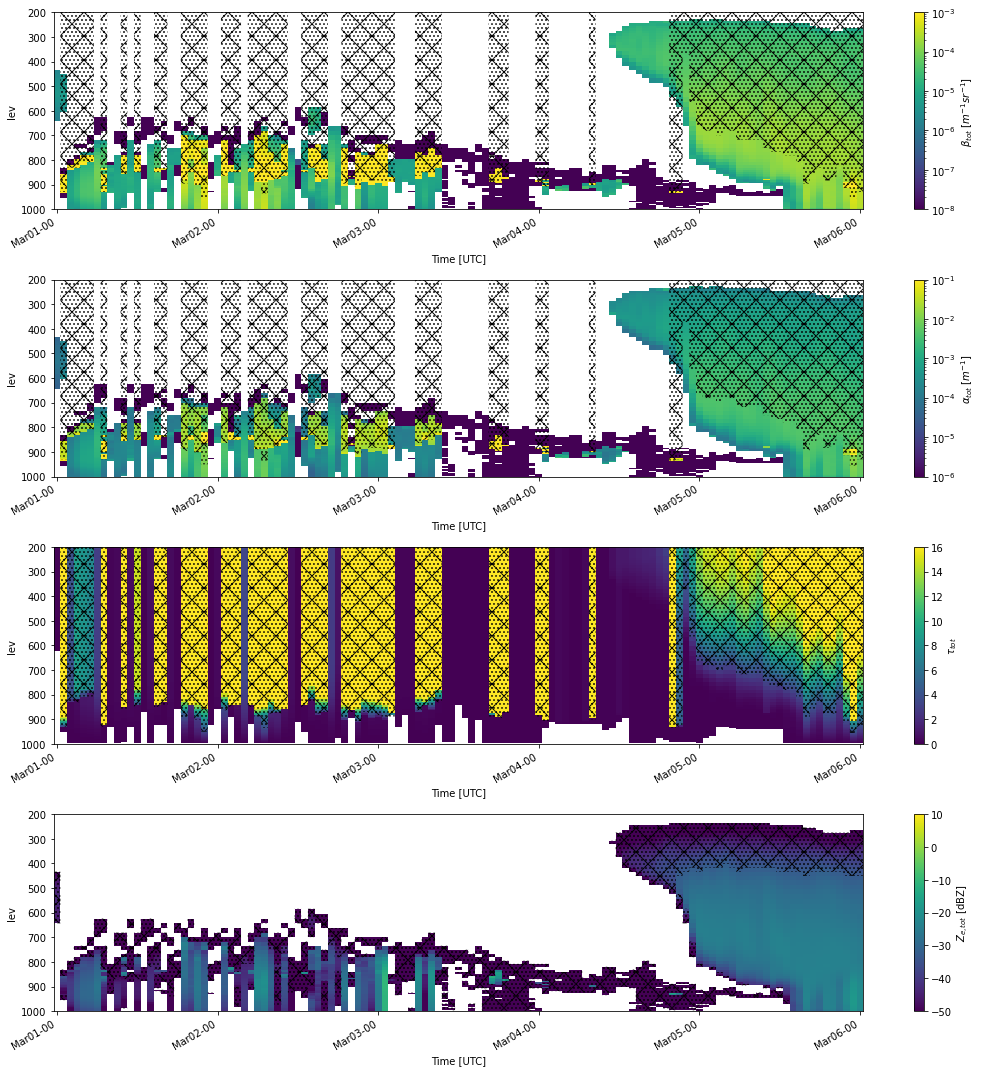

In [7]:
# Set input parameters.
cmap = 'viridis'
field_to_plot = ["sub_col_beta_p_tot", "sub_col_alpha_p_tot", "sub_col_OD_tot", "sub_col_Ze_att_tot"]
vmin_max = [(1e-8,1e-3), (1e-6, 1e-1), (0, 16), (-50., 10.)]
log_plot = [True, True, False, False]
is_radar_field = [False, False, False, True]
y_range = (200., 1e3)  # in hPa
subcol_ind = 0
ANX_coords = {"lat": 70.6, "lon": 14.9}

# Generate a SubcolumnDisplay object for coords closest to the NSA site
model_display = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(4, 1), figsize=(15,15),
                                               lat_sel=ANX_coords["lat"],
                                               lon_sel=ANX_coords["lon"], 
                                               tight_layout=True)

# set intrument detectability masks for KAZR and HSRL
Mask_array_KAZR_model = model_display.model.ds["detect_mask"]#.isel(subcolumn=subcol_ind)
Mask_array_HSRL_model = model_display.model.ds["ext_mask"]#.isel(subcolumn=subcol_ind)

# Plot variables
for ii in range(4):
    if is_radar_field[ii]:
        Mask_array=Mask_array_KAZR_model
    else:
        Mask_array=Mask_array_HSRL_model
    model_display.plot_subcolumn_timeseries(field_to_plot[ii], subcol_ind, log_plot=log_plot[ii], y_range=y_range,
                                            subplot_index=(ii),  cmap=cmap, title='',
                                            vmin=vmin_max[ii][0], vmax=vmin_max[ii][1],
                                            Mask_array=Mask_array, hatched_mask=True)

#### Recalling that EMC² outputs radar and lidar observables per hydrometeor class, we can examine a breakdown of hydrometeor contribution to every simulated observable. This type of analysis also enables the evaluation of the classification algorithm, generally speaking. Note that because we examine variables per hydrometeor class, we ignore the detectability constraints here. Also note that the user can quite easily edit the "cosmetics" (fontsize, etc.) when calling the plotting method, but we skip these options in this example.

cropping lat dim (lat requested = 70.60)


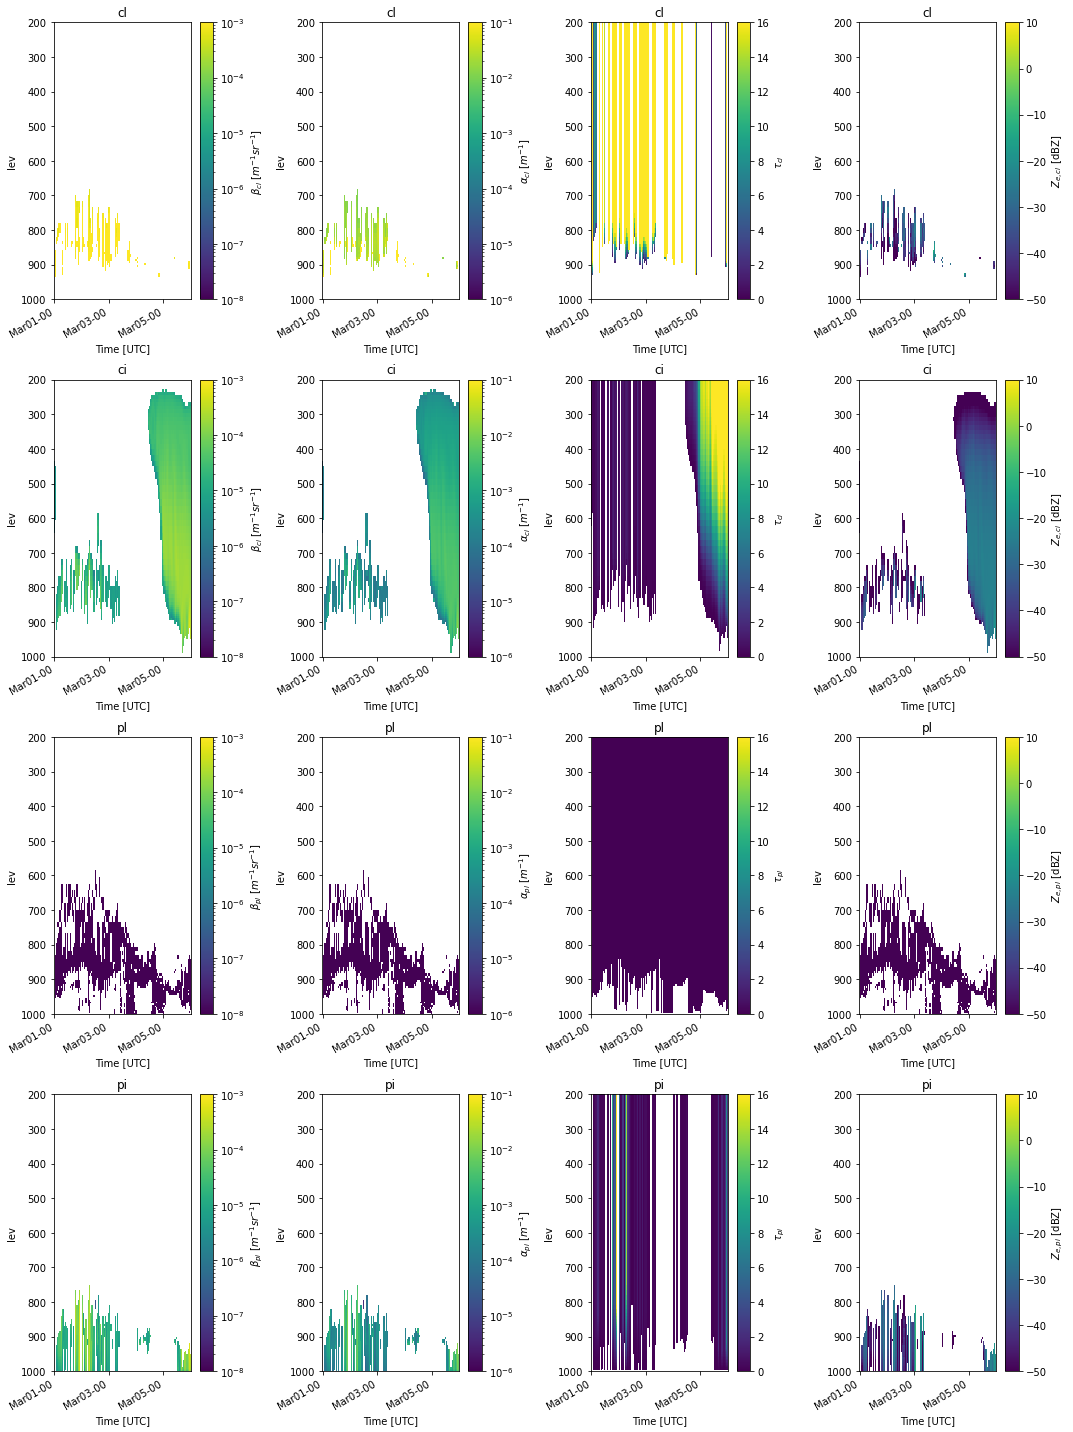

In [8]:
# Set additional input parameters.
field_to_plot_per_class = \
    ["sub_col_beta_p_%s_strat", "sub_col_alpha_p_%s_strat", "sub_col_OD_%s_strat", "sub_col_Ze_%s_strat"]
hyd_class = my_e3sm.hyd_types

# generate a SubcolumnDisplay object for coords closest to the NSA site.
model_display3 = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(len(hyd_class), 4), figsize=(15, 5 * len(hyd_class)),
                                               lat_sel=ANX_coords["lat"],
                                               lon_sel=ANX_coords["lon"], 
                                               tight_layout=True)

# Plot variables per hydrometeor class
for ii in range(4):
    for class_i in range(len(hyd_class)):
        if is_radar_field[ii]:
            Mask_array=Mask_array_KAZR_model
        else:
            Mask_array=Mask_array_HSRL_model
        model_display3.plot_subcolumn_timeseries(field_to_plot_per_class[ii] % hyd_class[class_i], subcol_ind,
                                                log_plot=log_plot[ii], y_range=y_range,
                                                subplot_index=(class_i, ii),  cmap=cmap, title=hyd_class[class_i],
                                                vmin=vmin_max[ii][0], vmax=vmin_max[ii][1])

## Concluding Remarks

#### EMC² includes support for a large number of instruments including the full ARM radar and lidar instrument suite and has already been operated on ESM, SCM, and LES outputs. The software include multiple methods for phase classification and partitioning, scattering calculations, and more. See and follow the continuously updated [EMC² GitHub repository](https://github.com/columncolab/EMC2) for more information.

## Resources and References

- [The EMC² manuscript (Silber et al. GMD, 2022)](https://doi.org/10.5194/gmd-15-901-2022)
- [EMC² documentation](https://columncolab.github.io/EMC2/)
- [EMC² source code](https://github.com/columncolab/EMC2)